In [ ]:
!pip install --upgrade scikit-learn

In [1]:
import sklearn
sklearn.__version__

'1.0.2'

In [42]:
#Load the libraries
import pandas as pd 
import numpy as np 

# For visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

In [43]:
df_credit = pd.read_csv("./german_credit_data.csv",index_col=0)
print(df_credit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


In [44]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [45]:
print("Purpose : ",df_credit.Purpose.unique())
print("Sex : ",df_credit.Sex.unique())
print("Housing : ",df_credit.Housing.unique())
print("Saving accounts : ",df_credit['Saving accounts'].unique())
print("Risk : ",df_credit['Risk'].unique())
print("Checking account : ",df_credit['Checking account'].unique())


Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']


## Sex & Age Distribution

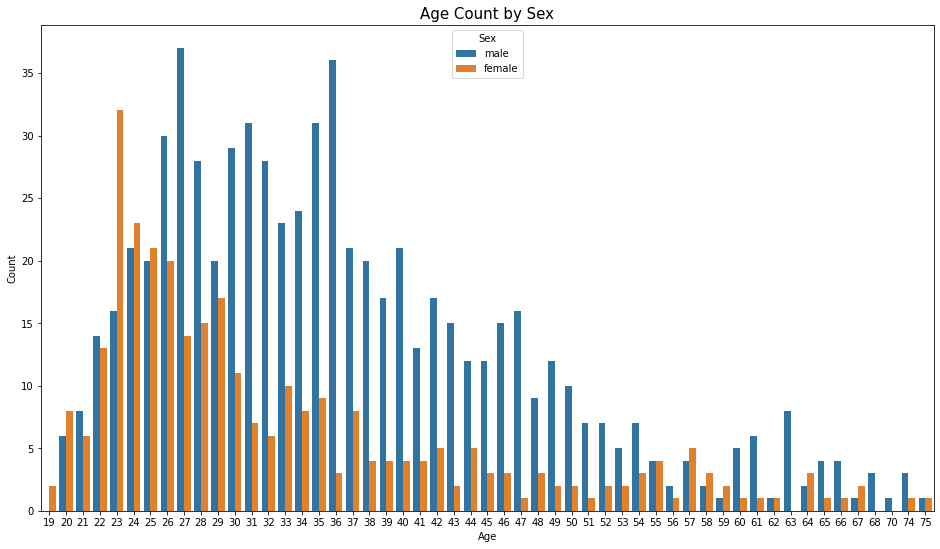

In [46]:
df_male = df_credit[df_credit["Sex"] == 'male']
df_female = df_credit[df_credit["Sex"] == 'female']

fig, ax = plt.subplots(nrows=1, figsize=(16,10))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g2 = sns.countplot(x="Age", data=df_credit, hue = "Sex")
g2.set_title("Age Count by Sex", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
plt.show()

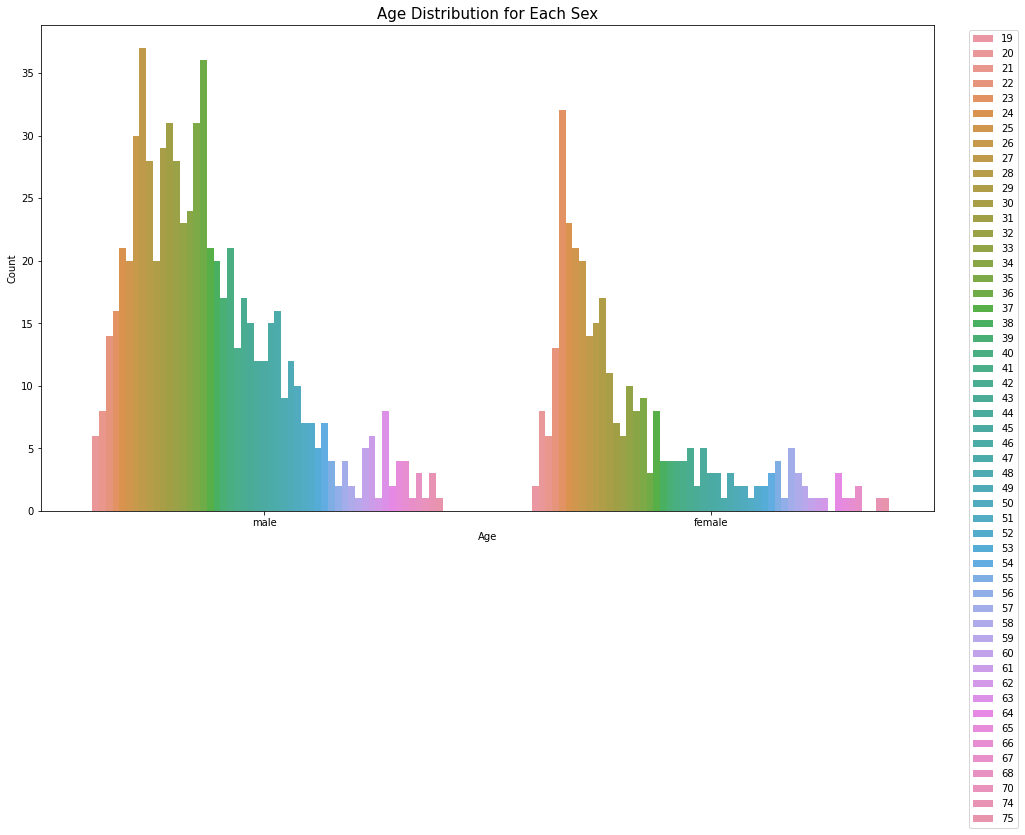

In [47]:
df_age = df_credit["Age"]

fig, ax = plt.subplots(nrows=1, figsize=(16,10))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g2 = sns.countplot(x="Sex", data=df_credit, hue = "Age")
g2.set_title("Age Distribution for Each Sex", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
g2.legend(loc="upper right",bbox_to_anchor=(1.1, 1),)
plt.show()

## Data Processing

In [48]:
#  Fill Missing Values
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#  Make age into buckets
interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)
del df_credit['Age']

#  Convert Categoricals into columns
categorical_columns = [('Purpose','Purpose'),('Sex','Sex'),('Housing','Housing'),
                       ('Saving accounts','Saving'),('Checking account','Checking'),
                      ('Age_cat','Age_Cat')]

for c in categorical_columns:
    df_credit = df_credit.merge(
                    pd.get_dummies(df_credit[c[0]], drop_first=True,prefix=c[1]),
                    left_index=True,
                    right_index=True
    )
    del df_credit[c[0]]

#  Risk needs special handling
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
del df_credit['Risk']

# not interested in this column for this assignment
del df_credit['Risk_good']
df_credit.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Job                          1000 non-null   int64
 1   Credit amount                1000 non-null   int64
 2   Duration                     1000 non-null   int64
 3   Purpose_car                  1000 non-null   uint8
 4   Purpose_domestic appliances  1000 non-null   uint8
 5   Purpose_education            1000 non-null   uint8
 6   Purpose_furniture/equipment  1000 non-null   uint8
 7   Purpose_radio/TV             1000 non-null   uint8
 8   Purpose_repairs              1000 non-null   uint8
 9   Purpose_vacation/others      1000 non-null   uint8
 10  Sex_male                     1000 non-null   uint8
 11  Housing_own                  1000 non-null   uint8
 12  Housing_rent                 1000 non-null   uint8
 13  Saving_moderate              1000 non-null   uint

## Correlation Matrix


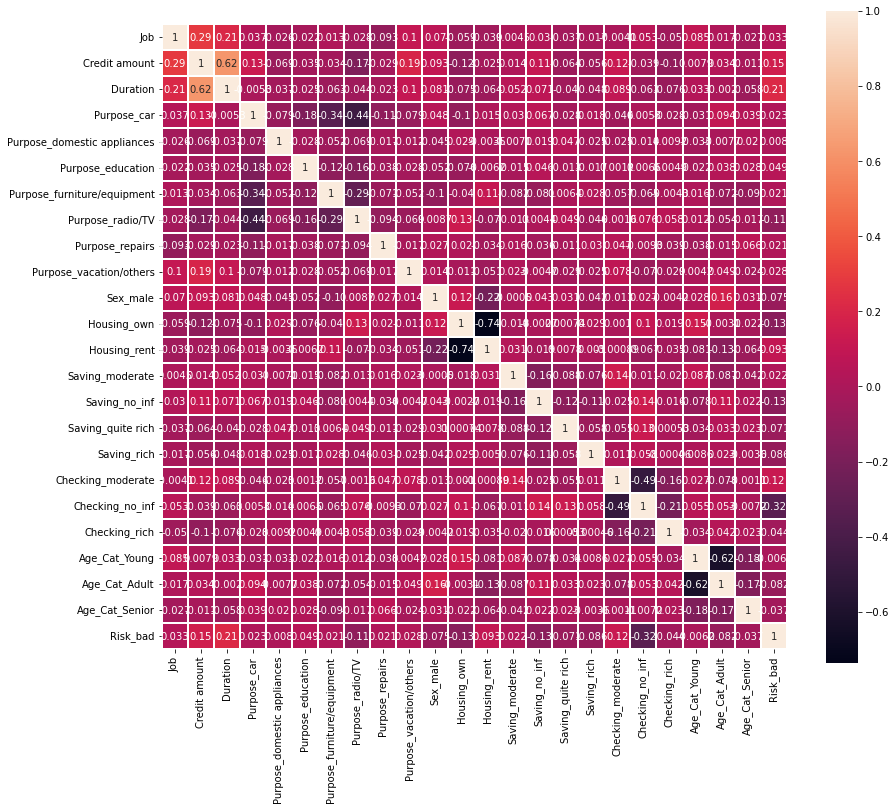

In [49]:
plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

# Task 1: Train Credit Scoring Model
## Random Forest Classifier

In [178]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, recall_score,precision_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

In [51]:
y = df_credit["Risk_bad"]
X = df_credit.drop('Risk_bad', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=69)

C:\Users\adity\AppData\Local\Temp/ipykernel_109184/1448530673.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_credit.drop('Risk_bad', 1)


In [52]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=420)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=420)

In [53]:
y_pred = rf.predict(X_test)
print("Accuracy:",str(accuracy_score(y_test,y_pred)))

Accuracy: 0.712


In [54]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[147  35]
 [ 37  31]]


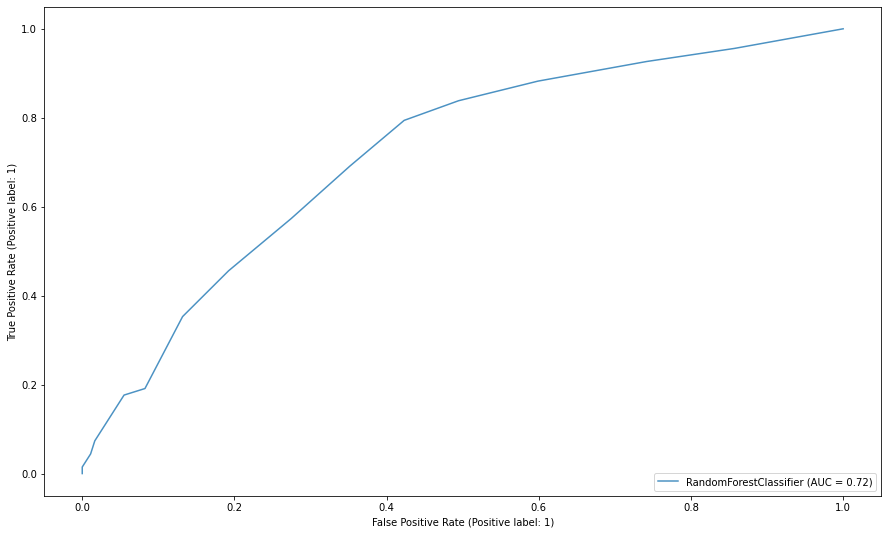

In [55]:
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# Task 2: Measuring Fairness
## (a) Anti-Classification
### (i) Gender

In [67]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [77]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [82]:
males=X_test.copy()
males=males.assign(Sex_male=1)
print('All values of Sex_male in test dataset after considering gender is male: ',males['Sex_male'].unique())
print('Length test dataset after considering gender is male:', len(males))

All values of Sex_male in test dataset after considering gender is male:  [1]
Length test dataset after considering gender is male: 250


In [84]:
females=X_test.copy()
females=females.assign(Sex_male=0)
print('All values of Sex_male in test dataset after considering gender is female: ',females['Sex_male'].unique())
print('Length test dataset after considering gender is female:', len(males))

All values of Sex_male in test dataset after considering gender is female:  [0]
Length test dataset after considering gender is female: 250


In [85]:
males_pred=rf.predict(males)
females_pred=rf.predict(females)

In [86]:
print("Accuracy when gender is considered male")
print(accuracy_score(y_test, males_pred))
print("Accuracy when gender is considered female")
print(accuracy_score(y_test, females_pred))

Accuracy when gender is considered male
0.716
Accuracy when gender is considered female
0.704


In [89]:
flipped_gender=X_test.copy()
flipped_gender['Sex_male']=flipped_gender['Sex_male'].replace({0:1, 1:0})

In [91]:
original_pred=rf.predict(X_test)
flipped_gender_pred=rf.predict(flipped_gender)
print("Accuracy of Original predictions")
print(accuracy_score(y_test, original_pred))
print("Accuracy when Gender is flipped")
print(accuracy_score(y_test,flipped_gender_pred))

Accuracy of Original predictions
0.712
Accuracy when Gender is flipped
0.708


In [93]:
print("Confusion Matrix when gender is considered male")
print(confusion_matrix(y_test, males_pred))
print("\nConfusion Matrix when gender is considered female")
print(confusion_matrix(y_test, females_pred))
print("\nConfusion Matrix of original predictions")
print(confusion_matrix(y_test, original_pred))
print("\nConfusion Matrix when gender is flipped")
print(confusion_matrix(y_test, flipped_gender_pred))

Confusion Matrix when gender is considered male
[[150  32]
 [ 39  29]]

Confusion Matrix when gender is considered female
[[143  39]
 [ 35  33]]

Confusion Matrix of original predictions
[[147  35]
 [ 37  31]]

Confusion Matrix when gender is flipped
[[146  36]
 [ 37  31]]


ROC curve when gender is considered male


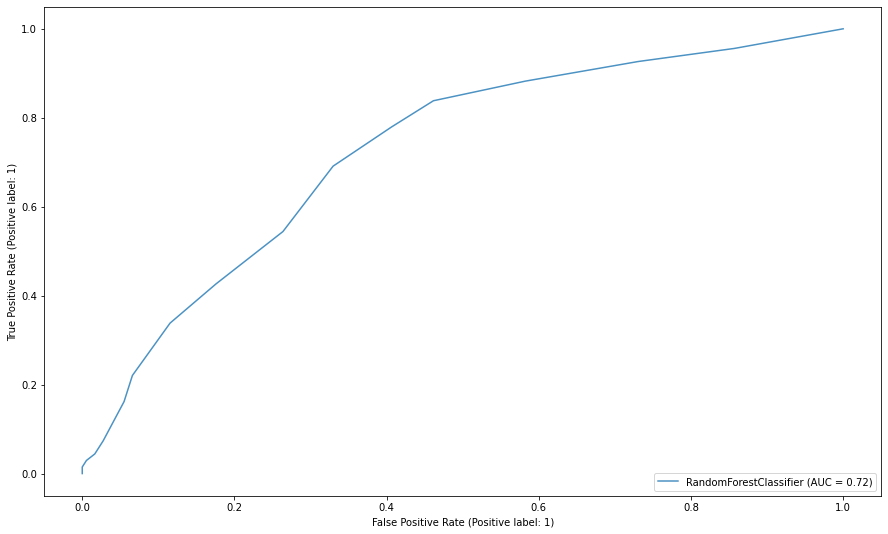

In [95]:
print('ROC curve when gender is considered male')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, males, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when gender is considered female


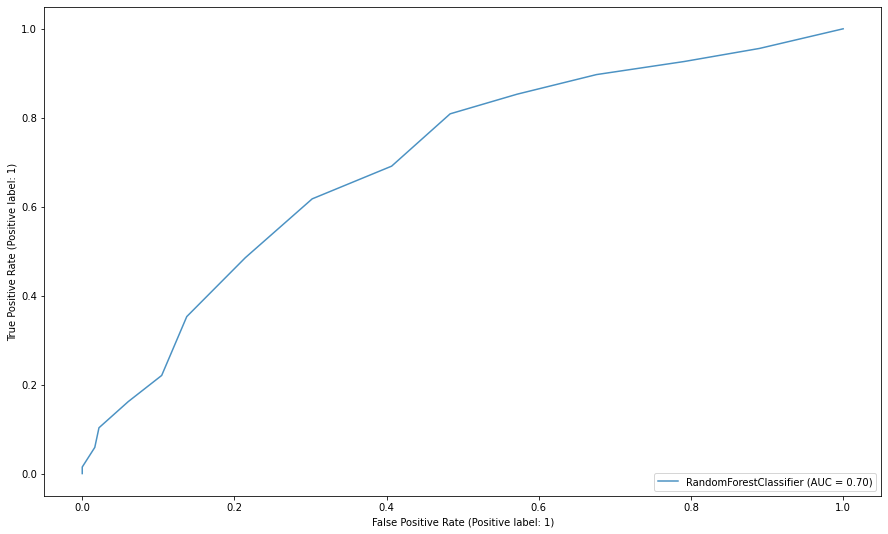

In [96]:
print('ROC curve when gender is considered female')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, females, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when gender is flipped


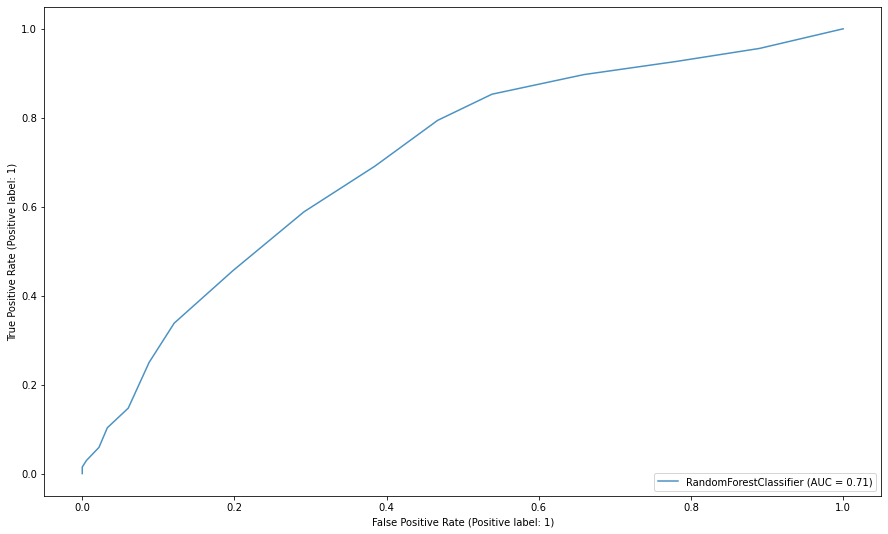

In [97]:
print('ROC curve when gender is flipped')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, flipped_gender, y_test, ax=ax, alpha=0.8)
plt.show()

In [99]:
print("Total length of predictions: ",len(y_pred))
print("Number of same predictions between when gender is considered male and female and predicted seperately: " , sum(males_pred==females_pred))

Total length of predictions:  250
Number of same predictions when gender is considered male and female and predicted seperately:  217


In [100]:
print("Total length of predictions: ",len(y_pred))
print("Number of same predictions between original predictions and when when gender is flipped: " , sum(flipped_gender_pred==y_pred))

Total length of predictions:  250
Number of same predictions between original predictions and when when gender is flipped:  217


### (ii) Age

In [101]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [102]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [112]:
student=X_test.copy()
student=student.assign(Age_Cat_Young=0,Age_Cat_Adult=0,Age_Cat_Senior=0)
print('All values of Age_Cat_Young in test dataset after considering cat_age as student: ',student["Age_Cat_Young"].unique())
print('All values of Age_Cat_Adult in test dataset after considering cat_age as student: ',student["Age_Cat_Adult"].unique())
print('All values of Age_Cat_Senior in test dataset after considering cat_age as student: ',student["Age_Cat_Senior"].unique())
print('Length test dataset after considering cat_age as student:', len(student))

All values of Age_Cat_Young in test dataset after considering cat_age as student:  [0]
All values of Age_Cat_Adult in test dataset after considering cat_age as student:  [0]
All values of Age_Cat_Senior in test dataset after considering cat_age as student:  [0]
Length test dataset after considering cat_age as student: 250


In [109]:
young=X_test.copy()
young=young.assign(Age_Cat_Young=1,Age_Cat_Adult=0,Age_Cat_Senior=0)
print('All values of Age_Cat_Young in test dataset after considering cat_age as young: ',young["Age_Cat_Young"].unique())
print('All values of Age_Cat_Adult in test dataset after considering cat_age as young: ',young["Age_Cat_Adult"].unique())
print('All values of Age_Cat_Senior in test dataset after considering cat_age as young: ',young["Age_Cat_Senior"].unique())
print('Length test dataset after considering cat_age as young:', len(young))

All values of Age_Cat_Young in test dataset after considering cat_age as young:  [1]
All values of Age_Cat_Adult in test dataset after considering cat_age as young:  [0]
All values of Age_Cat_Senior in test dataset after considering cat_age as young:  [0]
Length test dataset after considering cat_age as young: 250


In [110]:
adult=X_test.copy()
adult=adult.assign(Age_Cat_Young=0,Age_Cat_Adult=1,Age_Cat_Senior=0)
print('All values of Age_Cat_Young in test dataset after considering cat_age as adult: ',adult["Age_Cat_Young"].unique())
print('All values of Age_Cat_Adult in test dataset after considering cat_age as adult: ',adult["Age_Cat_Adult"].unique())
print('All values of Age_Cat_Senior in test dataset after considering cat_age as adult: ',adult["Age_Cat_Senior"].unique())
print('Length test dataset after considering cat_age as adult:', len(adult))

All values of Age_Cat_Young in test dataset after considering cat_age as adult:  [0]
All values of Age_Cat_Adult in test dataset after considering cat_age as adult:  [1]
All values of Age_Cat_Senior in test dataset after considering cat_age as adult:  [0]
Length test dataset after considering cat_age as adult: 250


In [111]:
senior=X_test.copy()
senior=senior.assign(Age_Cat_Young=0,Age_Cat_Adult=0,Age_Cat_Senior=1)
print('All values of Age_Cat_Young in test dataset after considering cat_age as senior: ',senior["Age_Cat_Young"].unique())
print('All values of Age_Cat_Adult in test dataset after considering cat_age as senior: ',senior["Age_Cat_Adult"].unique())
print('All values of Age_Cat_Senior in test dataset after considering cat_age as senior: ',senior["Age_Cat_Senior"].unique())
print('Length test dataset after considering cat_age as senior:', len(senior))

All values of Age_Cat_Young in test dataset after considering cat_age as senior:  [0]
All values of Age_Cat_Adult in test dataset after considering cat_age as senior:  [0]
All values of Age_Cat_Senior in test dataset after considering cat_age as senior:  [1]
Length test dataset after considering cat_age as senior: 250


In [113]:
student_pred=rf.predict(student)
young_pred=rf.predict(young)
adult_pred=rf.predict(adult)
senior_pred=rf.predict(senior)

In [114]:
print("Accuracy of original test set")
print(accuracy_score(y_test, y_pred))
print("Accuracy when cat_age is considered student")
print(accuracy_score(y_test, student_pred))
print("Accuracy when cat_age is considered young")
print(accuracy_score(y_test, young_pred))
print("Accuracy when cat_age is considered adult")
print(accuracy_score(y_test, adult_pred))
print("Accuracy when cat_age is considered senior")
print(accuracy_score(y_test, senior_pred))

Accuracy of original test set
0.712
Accuracy when cat_age is considered student
0.688
Accuracy when cat_age is considered young
0.712
Accuracy when cat_age is considered adult
0.712
Accuracy when cat_age is considered senior
0.704


In [115]:
print("Confusion Matrix of original predictions")
print(confusion_matrix(y_test, original_pred))
print("\nConfusion Matrix when cat_age is considered student")
print(confusion_matrix(y_test, student_pred))
print("\nConfusion Matrix when cat_age is considered young")
print(confusion_matrix(y_test, young_pred))
print("\nConfusion Matrix when cat_age is considered adult")
print(confusion_matrix(y_test, adult_pred))
print("\nConfusion Matrix when cat_age is considered senior")
print(confusion_matrix(y_test, senior_pred))

Confusion Matrix of original predictions
[[147  35]
 [ 37  31]]

Confusion Matrix when cat_age is considered student
[[143  39]
 [ 39  29]]

Confusion Matrix when cat_age is considered young
[[143  39]
 [ 33  35]]

Confusion Matrix when cat_age is considered adult
[[154  28]
 [ 44  24]]

Confusion Matrix when cat_age is considered senior
[[151  31]
 [ 43  25]]


ROC curve when is cat_age considered student


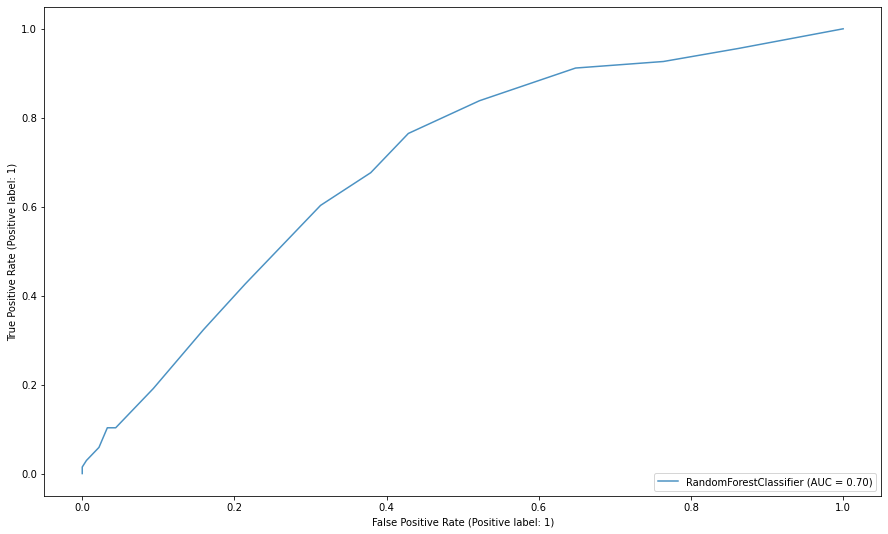

In [117]:
print('ROC curve when is cat_age considered student')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, student, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when is cat_age considered young


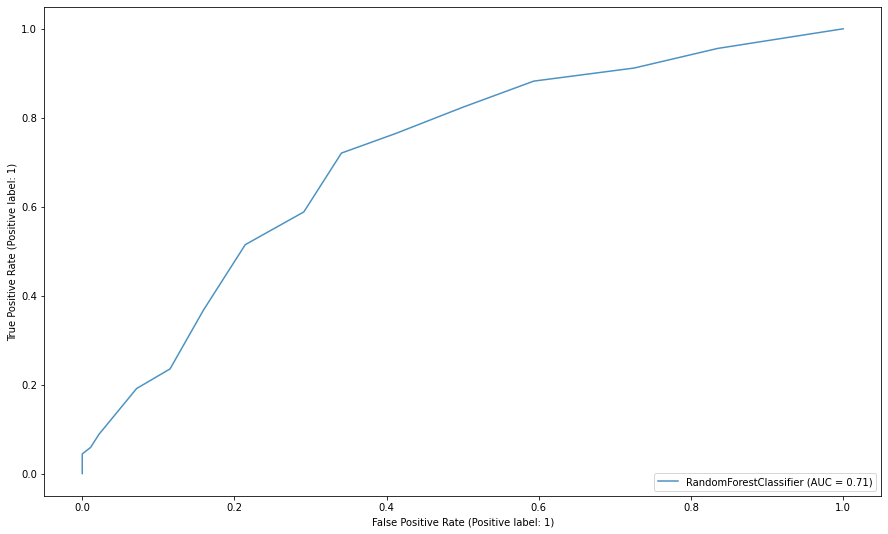

In [118]:
print('ROC curve when is cat_age considered young')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, young, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when is cat_age considered adult


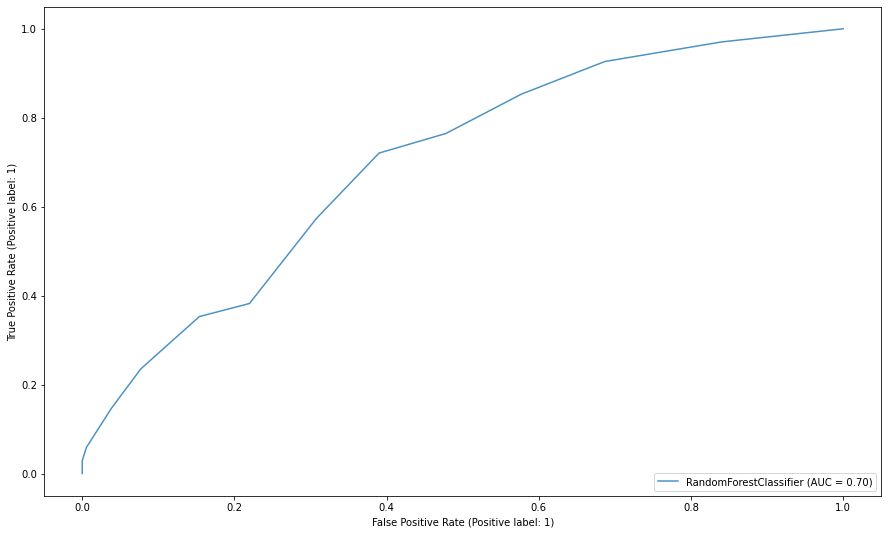

In [119]:
print('ROC curve when is cat_age considered adult')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, adult, y_test, ax=ax, alpha=0.8)
plt.show()

ROC curve when is cat_age considered senior


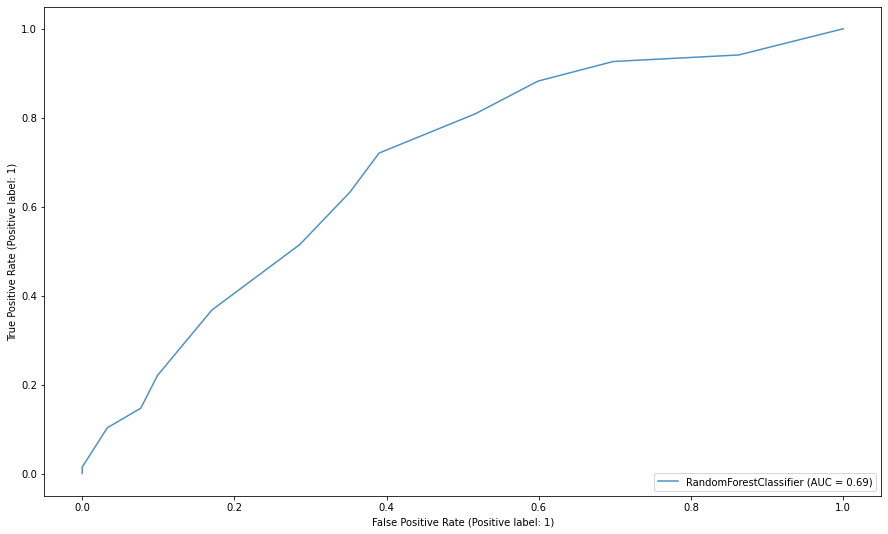

In [120]:
print('ROC curve when is cat_age considered senior')
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf, senior, y_test, ax=ax, alpha=0.8)
plt.show()

## (b) Independence
### (i) Gender

In [121]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [122]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [130]:
males=X_test[X_test["Sex_male"]==1]
females=X_test[X_test["Sex_male"]==0]

In [135]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))
males_pred = rf.predict(males)
females_pred = rf.predict(females)

Number of males in test set:  182
Number of females in test set:  68


In [136]:
print("Probability of Y==1 given gender is male: ", sum(males_pred)/len(males_pred))
print("Probability of Y==1 given gender is female: ", sum(females_pred)/len(females_pred))

Probability of Y==1 given gender is male:  0.22527472527472528
Probability of Y==1 given gender is female:  0.36764705882352944


### (ii) Age

In [123]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [124]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [126]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [125]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [146]:
student=X_test[X_test["Age_Cat_Young"]==0]
student=student[student["Age_Cat_Adult"]==0]
student=student[student["Age_Cat_Senior"]==0]
young=X_test[X_test["Age_Cat_Young"]==1]
adult=X_test[X_test["Age_Cat_Adult"]==1]
senior=X_test[X_test["Age_Cat_Senior"]==1]

In [147]:
print("Number of student in test set: ",len(student))
print("Number of young individuals in test set: ",len(young))
print("Number of adults in test set: ",len(adult))
print("Number of seniors in test set: ",len(senior))

Number of student in test set:  46
Number of young individuals in test set:  95
Number of adults in test set:  100
Number of seniors in test set:  9


In [148]:
student_pred = rf.predict(student)
young_pred = rf.predict(young)
adult_pred = rf.predict(adult)
senior = rf.predict(senior)

In [149]:
print("Probability of Y==1 given cat_age is student: ", sum(student_pred)/len(student_pred))
print("Probability of Y==1 given cat_age is young: ", sum(young_pred)/len(young_pred))
print("Probability of Y==1 given cat_age is adult: ", sum(adult_pred)/len(adult_pred))
print("Probability of Y==1 given cat_age is senior: ", sum(senior_pred)/len(senior_pred))

Probability of Y==1 given cat_age is student:  0.34782608695652173
Probability of Y==1 given cat_age is young:  0.23157894736842105
Probability of Y==1 given cat_age is adult:  0.25
Probability of Y==1 given cat_age is senior:  0.224


## (c) Seperation
### (i) Gender

In [169]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [170]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [171]:
test_with_labels=X_test.copy()
test_with_labels=test_with_labels.assign(Risk_bad=y_test)
test_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 823 to 441
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Job                          250 non-null    int64
 1   Credit amount                250 non-null    int64
 2   Duration                     250 non-null    int64
 3   Purpose_car                  250 non-null    uint8
 4   Purpose_domestic appliances  250 non-null    uint8
 5   Purpose_education            250 non-null    uint8
 6   Purpose_furniture/equipment  250 non-null    uint8
 7   Purpose_radio/TV             250 non-null    uint8
 8   Purpose_repairs              250 non-null    uint8
 9   Purpose_vacation/others      250 non-null    uint8
 10  Sex_male                     250 non-null    uint8
 11  Housing_own                  250 non-null    uint8
 12  Housing_rent                 250 non-null    uint8
 13  Saving_moderate              250 non-null    uin

In [172]:
males=test_with_labels[test_with_labels["Sex_male"]==1]
females=test_with_labels[test_with_labels["Sex_male"]==0]

In [173]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))

Number of males in test set:  182
Number of females in test set:  68


In [174]:
males_labels=males['Risk_bad']
females_labels=females['Risk_bad']
males=males.drop('Risk_bad', 1)
females=females.drop("Risk_bad",1)
print(males.columns)
print(females.columns)

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')
Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')


C:\Users\adity\AppData\Local\Temp/ipykernel_109184/366436962.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  males=males.drop('Risk_bad', 1)
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/366436962.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  females=females.drop("Risk_bad",1)


In [175]:
males_pred=rf.predict(males)
females_pred=rf.predict(females)

In [180]:
males_matrix=confusion_matrix(males_labels, males_pred)
print("Confusion Matrix for males:")
print(males_matrix)
print("\nFalse Positive Rate for males: ", males_matrix[0][1]/(males_matrix[0][1]+males_matrix[1][1]))
print("False Negative Rate for males: ", males_matrix[1][0]/(males_matrix[1][0]+males_matrix[0][0]))
print("\nPrecision Score for males: ", precision_score(males_labels, males_pred))
print("Recall Score for males: ", recall_score(males_labels, males_pred))
print("F1 Score for males: ", f1_score(males_labels, males_pred))


Confusion Matrix for males:
[[111  22]
 [ 30  19]]

False Positive Rate for males:  0.5365853658536586
False Negative Rate for males:  0.2127659574468085

Precision Score for males:  0.4634146341463415
Recall Score for males:  0.3877551020408163
F1 Score for males:  0.4222222222222223


In [181]:
females_matrix=confusion_matrix(females_labels, females_pred)
print("Confusion Matrix for females:")
print(females_matrix)
print("\nFalse Positive Rate for females: ", females_matrix[0][1]/(females_matrix[0][1]+females_matrix[1][1]))
print("False Negative Rate for females: ", females_matrix[1][0]/(females_matrix[1][0]+females_matrix[0][0]))
print("\nPrecision Score for females: ", precision_score(females_labels, females_pred))
print("Recall Score for females: ", recall_score(females_labels, females_pred))
print("F1 Score for females: ", f1_score(females_labels, females_pred))


Confusion Matrix for females:
[[36 13]
 [ 7 12]]

False Positive Rate for females:  0.52
False Negative Rate for females:  0.16279069767441862

Precision Score for females:  0.48
Recall Score for females:  0.631578947368421
F1 Score for females:  0.5454545454545454


### (ii) Age

In [127]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior', 'Risk_bad'],
      dtype='object')

In [128]:
print("Original test set length")
print(len(X_test))

Original test set length
250


In [182]:
test_with_labels=X_test.copy()
test_with_labels=test_with_labels.assign(Risk_bad=y_test)
test_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 823 to 441
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Job                          250 non-null    int64
 1   Credit amount                250 non-null    int64
 2   Duration                     250 non-null    int64
 3   Purpose_car                  250 non-null    uint8
 4   Purpose_domestic appliances  250 non-null    uint8
 5   Purpose_education            250 non-null    uint8
 6   Purpose_furniture/equipment  250 non-null    uint8
 7   Purpose_radio/TV             250 non-null    uint8
 8   Purpose_repairs              250 non-null    uint8
 9   Purpose_vacation/others      250 non-null    uint8
 10  Sex_male                     250 non-null    uint8
 11  Housing_own                  250 non-null    uint8
 12  Housing_rent                 250 non-null    uint8
 13  Saving_moderate              250 non-null    uin

In [183]:
student=test_with_labels[test_with_labels["Age_Cat_Young"]==0]
student=student[test_with_labels["Age_Cat_Adult"]==0]
student=student[test_with_labels["Age_Cat_Senior"]==0]
young=test_with_labels[test_with_labels["Age_Cat_Young"]==1]
adult=test_with_labels[test_with_labels["Age_Cat_Adult"]==1]
senior=test_with_labels[test_with_labels["Age_Cat_Senior"]==1]

C:\Users\adity\AppData\Local\Temp/ipykernel_109184/3348569278.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  student=student[test_with_labels["Age_Cat_Adult"]==0]
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/3348569278.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  student=student[test_with_labels["Age_Cat_Senior"]==0]


In [184]:
print("Number of student in test set: ",len(student))
print("Number of young individuals in test set: ",len(young))
print("Number of adults in test set: ",len(adult))
print("Number of seniors in test set: ",len(senior))

Number of student in test set:  46
Number of young individuals in test set:  95
Number of adults in test set:  100
Number of seniors in test set:  9


In [185]:
student_labels=student['Risk_bad']
young_labels=young['Risk_bad']
adult_labels=adult['Risk_bad']
senior_labels=senior['Risk_bad']
student=student.drop('Risk_bad', 1)
young=young.drop("Risk_bad",1)
adult=adult.drop('Risk_bad', 1)
senior=senior.drop("Risk_bad",1)
print(student.columns)
print(young.columns)
print(adult.columns)
print(senior.columns)

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')
Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')
Index(['

C:\Users\adity\AppData\Local\Temp/ipykernel_109184/2559380518.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  student=student.drop('Risk_bad', 1)
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/2559380518.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  young=young.drop("Risk_bad",1)
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/2559380518.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  adult=adult.drop('Risk_bad', 1)
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/2559380518.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  senior=senior.drop("Risk_bad",1)


In [186]:
student_pred=rf.predict(student)
young_pred=rf.predict(young)
adult_pred=rf.predict(adult)
senior_pred=rf.predict(senior)

In [189]:
student_matrix=confusion_matrix(student_labels, student_pred)
print("Confusion Matrix for students:")
print(student_matrix)
print("\nFalse Positive Rate for students: ", student_matrix[0][1]/(student_matrix[0][1]+student_matrix[1][1]))
print("False Negative Rate for students: ", student_matrix[1][0]/(student_matrix[1][0]+student_matrix[0][0]))
print("\nPrecision Score for students: ", precision_score(student_labels, student_pred))
print("Recall Score for students: ", recall_score(student_labels, student_pred))
print("F1 Score for students: ", f1_score(student_labels, student_pred))

Confusion Matrix for students:
[[21  8]
 [ 9  8]]

False Positive Rate for students:  0.5
False Negative Rate for students:  0.3

Precision Score for students:  0.5
Recall Score for students:  0.47058823529411764
F1 Score for students:  0.48484848484848486


In [192]:
young_matrix=confusion_matrix(young_labels, young_pred)
print("Confusion Matrix for young individuals:")
print(young_matrix)
print("\nFalse Positive Rate for young individuals: ", young_matrix[0][1]/(young_matrix[0][1]+young_matrix[1][1]))
print("False Negative Rate for young individuals: ", young_matrix[1][0]/(young_matrix[1][0]+young_matrix[0][0]))
print("\nPrecision Score for young individuals: ", precision_score(young_labels, young_pred))
print("Recall Score for young individuals: ", recall_score(young_labels, young_pred))
print("F1 Score for young individuals: ", f1_score(young_labels, young_pred))

Confusion Matrix for young individuals:
[[61 11]
 [12 11]]

False Positive Rate for young individuals:  0.5
False Negative Rate for young individuals:  0.1643835616438356

Precision Score for young individuals:  0.5
Recall Score for young individuals:  0.4782608695652174
F1 Score for young individuals:  0.4888888888888889


In [193]:
adult_matrix=confusion_matrix(adult_labels, adult_pred)
print("Confusion Matrix for adults:")
print(adult_matrix)
print("\nFalse Positive Rate for adults: ", adult_matrix[0][1]/(adult_matrix[0][1]+adult_matrix[1][1]))
print("False Negative Rate for adults: ", adult_matrix[1][0]/(adult_matrix[1][0]+adult_matrix[0][0]))
print("\nPrecision Score for adults: ", precision_score(adult_labels, adult_pred))
print("Recall Score for adults: ", recall_score(adult_labels, adult_pred))
print("F1 Score for adults: ", f1_score(adult_labels, adult_pred))

Confusion Matrix for adults:
[[61 13]
 [14 12]]

False Positive Rate for adults:  0.52
False Negative Rate for adults:  0.18666666666666668

Precision Score for adults:  0.48
Recall Score for adults:  0.46153846153846156
F1 Score for adults:  0.47058823529411764


In [194]:
senior_matrix=confusion_matrix(senior_labels, senior_pred)
print("Confusion Matrix for seniors:")
print(senior_matrix)
print("\nFalse Positive Rate for seniors: ", senior_matrix[0][1]/(senior_matrix[0][1]+senior_matrix[1][1]))
print("False Negative Rate for seniors: ", senior_matrix[1][0]/(senior_matrix[1][0]+senior_matrix[0][0]))
print("\nPrecision Score for seniors: ", precision_score(senior_labels, senior_pred))
print("Recall Score for seniors: ", recall_score(senior_labels, senior_pred))
print("F1 Score for seniors: ", f1_score(senior_labels, senior_pred))

Confusion Matrix for seniors:
[[4 3]
 [2 0]]

False Positive Rate for seniors:  1.0
False Negative Rate for seniors:  0.3333333333333333

Precision Score for seniors:  0.0
Recall Score for seniors:  0.0
F1 Score for seniors:  0.0


# Task 3: Improve model fairness
## (a) Anti-Classification
### (i) Gender

For anti-classification we will make the model blind to the "gender" protected attribute. For this we will drop the "Sex_male" variable from our data and train a new classification model.

In [216]:
X_train.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')

In [195]:
X_train_3a=X_train.copy()
X_test_3a=X_test.copy()
X_train_3a=X_train_3a.drop("Sex_male",1)
X_test_3a=X_test_3a.drop("Sex_male",1)

C:\Users\adity\AppData\Local\Temp/ipykernel_109184/1512586920.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train_3a=X_train_3a.drop("Sex_male",1)
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/1512586920.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test_3a=X_test_3a.drop("Sex_male",1)


In [199]:
print(X_train_3a.columns)
print(X_test_3a.columns)

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')
Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')


In [196]:
rf_3a=RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf_3a.fit(X_train_3a,y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

In [197]:
pred_3a=rf_3a.predict(X_test_3a)

In [206]:
print('Original Accuracy of model:', accuracy_score(y_test,y_pred))
print('Accuracy of fairer model:', accuracy_score(y_test,pred_3a))

Original Accuracy of model: 0.712
Accuracy of fairer model: 0.712


In [207]:
print("Confusion Matrix of original model:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix of original model:
 [[147  35]
 [ 37  31]]


In [208]:
print("Confusion Matrix of fairer model:\n", confusion_matrix(y_test, pred_3a))

Confusion Matrix of fairer model:
 [[146  36]
 [ 36  32]]


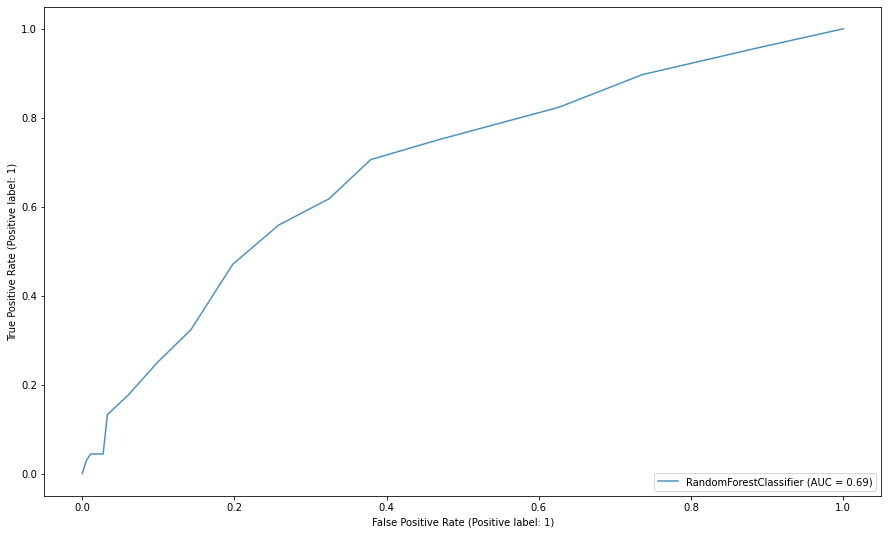

In [209]:
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_3a, X_test_3a, y_test, ax=ax, alpha=0.8)
plt.show()

## (ii) Age
We will now also remove the age attribute

In [213]:
X_train.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich',
       'Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],
      dtype='object')

In [215]:
X_train_3a_2=X_train.copy()
X_test_3a_2=X_test.copy()
X_train_3a_2=X_train_3a_2.drop(['Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],1)
X_test_3a_2=X_test_3a_2.drop(['Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],1)

C:\Users\adity\AppData\Local\Temp/ipykernel_109184/394800475.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train_3a_2=X_train_3a_2.drop(['Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],1)
C:\Users\adity\AppData\Local\Temp/ipykernel_109184/394800475.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test_3a_2=X_test_3a_2.drop(['Age_Cat_Young', 'Age_Cat_Adult', 'Age_Cat_Senior'],1)


In [217]:
print(X_train_3a_2.columns)
print(X_test_3a_2.columns)

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich'],
      dtype='object')
Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving_moderate', 'Saving_no_inf', 'Saving_quite rich', 'Saving_rich',
       'Checking_moderate', 'Checking_no_inf', 'Checking_rich'],
      dtype='object')


In [218]:
rf_3a_2=RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf_3a_2.fit(X_train_3a_2,y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

In [220]:
pred_3a_2=rf_3a_2.predict(X_test_3a_2)

In [221]:
print('Original Accuracy of model:', accuracy_score(y_test,y_pred))
print('Accuracy of fairer model:', accuracy_score(y_test,pred_3a_2))

Original Accuracy of model: 0.712
Accuracy of fairer model: 0.712


In [222]:
print("Confusion Matrix of original model:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix of original model:
 [[147  35]
 [ 37  31]]


In [224]:
print("Confusion Matrix of fairer model:\n", confusion_matrix(y_test, pred_3a_2))

Confusion Matrix of fairer model:
 [[152  30]
 [ 42  26]]


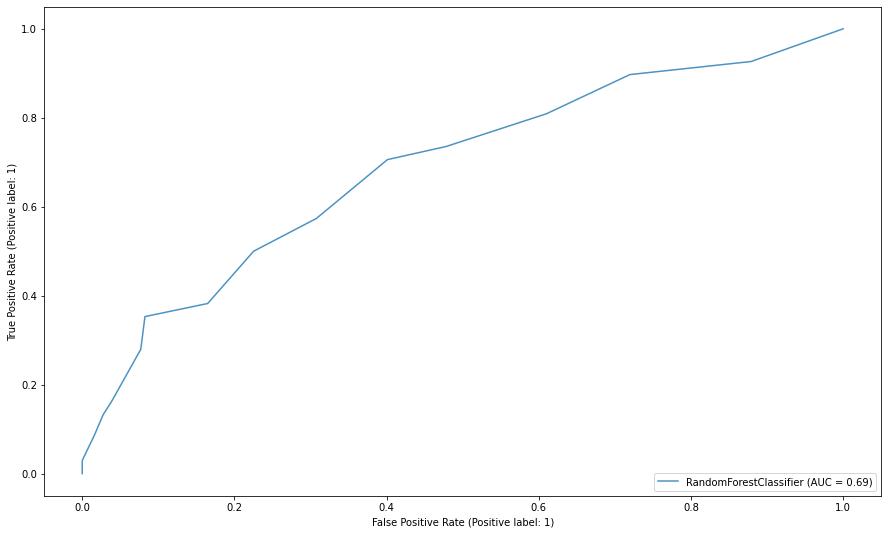

In [225]:
plt.figure(figsize=((15,9)))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_3a_2, X_test_3a_2, y_test, ax=ax, alpha=0.8)
plt.show()

## (b) Independence
### (i) Gender

We will use predict_proba and change the threshold for classification. Since we saw that females had a higher probability of Y==1 (getting the label as high risk) we will either reduce the threshold for Sex_male=0

In [226]:
males=X_test[X_test["Sex_male"]==1]
females=X_test[X_test["Sex_male"]==0]

In [244]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))
males_pred_proba = rf.predict_proba(males)
females_pred_proba = rf.predict_proba(females)

Number of males in test set:  182
Number of females in test set:  68


In [250]:
males_pred = males_pred_proba[:,0] < 0.5
females_pred = females_pred_proba[:,0] < 0.45

In [251]:
print("Probability of Y==1 given gender is male: ", sum(males_pred)/len(males_pred))
print("Probability of Y==1 given gender is female: ", sum(females_pred)/len(females_pred))

Probability of Y==1 given gender is male:  0.22527472527472528
Probability of Y==1 given gender is female:  0.25


In [263]:
male_accuracy=accuracy_score(males_labels,males_pred)
female_accuracy=accuracy_score(females_labels,females_pred)
print("Accuracy for males: ",male_accuracy)
print("Accuracy for females: ",female_accuracy)

print('Original model accuracy:', accuracy_score(y_test,y_pred))
fair_model_accuracy=(len(males_labels)*male_accuracy +len(females_labels)*female_accuracy)/len(y_test)
print("Fairer model accuracy: ", fair_model_accuracy)

Accuracy for males:  0.7142857142857143
Accuracy for females:  0.7058823529411765
Original model accuracy: 0.712
Fairer model accuracy:  0.712


In [264]:
print("Confusion Matrix for males:\n", confusion_matrix(males_labels,males_pred))
print("\nConfusion Matrix for females:\n", confusion_matrix(females_labels,females_pred))

Confusion Matrix for males:
 [[111  22]
 [ 30  19]]

Confusion Matrix for females:
 [[40  9]
 [11  8]]


### (ii) Age
Now we will try the same for age. Since students had a high probability of Y==1 we will reduce the threshold for students.

In [253]:
student=X_test[X_test["Age_Cat_Young"]==0]
student=student[student["Age_Cat_Adult"]==0]
student=student[student["Age_Cat_Senior"]==0]
young=X_test[X_test["Age_Cat_Young"]==1]
adult=X_test[X_test["Age_Cat_Adult"]==1]
senior=X_test[X_test["Age_Cat_Senior"]==1]

In [256]:
student_pred_proba = rf.predict_proba(student)
young_pred_proba = rf.predict_proba(young)
adult_pred_proba = rf.predict_proba(adult)
senior_pred_proba = rf.predict_proba(senior)

In [258]:
student_pred = student_pred_proba[:,0] < 0.45
young_pred = young_pred_proba[:,0] < 0.5
adult_pred = adult_pred_proba[:,0] < 0.5
senior_pred = senior_pred_proba[:,0] < 0.5

In [259]:
print("Probability of Y==1 given cat_age is student: ", sum(student_pred)/len(student_pred))
print("Probability of Y==1 given cat_age is young: ", sum(young_pred)/len(young_pred))
print("Probability of Y==1 given cat_age is adult: ", sum(adult_pred)/len(adult_pred))
print("Probability of Y==1 given cat_age is senior: ", sum(senior_pred)/len(senior_pred))

Probability of Y==1 given cat_age is student:  0.2608695652173913
Probability of Y==1 given cat_age is young:  0.23157894736842105
Probability of Y==1 given cat_age is adult:  0.25
Probability of Y==1 given cat_age is senior:  0.3333333333333333


In [265]:
student_accuracy=accuracy_score(student_labels,student_pred)
young_accuracy=accuracy_score(young_labels,young_pred)
adult_accuracy=accuracy_score(adult_labels,adult_pred)
senior_accuracy=accuracy_score(senior_labels,senior_pred)
print("Accuracy for students: ",student_accuracy)
print("Accuracy for young individuals: ",young_accuracy)
print("Accuracy for adults: ",adult_accuracy)
print("Accuracy for seniors: ",senior_accuracy)

print('Original model accuracy:', accuracy_score(y_test,y_pred))
fair_model_accuracy=(len(student_labels)*student_accuracy +len(young_labels)*young_accuracy+len(adult_labels)*adult_accuracy +len(senior_labels)*senior_accuracy)/len(y_test)
print("Fairer model accuracy: ", fair_model_accuracy)

Accuracy for students:  0.5869565217391305
Accuracy for young individuals:  0.7578947368421053
Accuracy for adults:  0.73
Accuracy for seniors:  0.4444444444444444
Original model accuracy: 0.712
Fairer model accuracy:  0.704


In [266]:
print("Confusion Matrix for students:\n", confusion_matrix(student_labels,student_pred))
print("\nConfusion Matrix for young individuals:\n", confusion_matrix(young_labels,young_pred))
print("\nConfusion Matrix for adults:\n", confusion_matrix(adult_labels,adult_pred))
print("\nConfusion Matrix for seniors:\n", confusion_matrix(senior_labels,senior_pred))

Confusion Matrix for students:
 [[22  7]
 [12  5]]

Confusion Matrix for young individuals:
 [[61 11]
 [12 11]]

Confusion Matrix for adults:
 [[61 13]
 [14 12]]

Confusion Matrix for seniors:
 [[4 3]
 [2 0]]


## (c) Seperation
### (i) Age

We will employ a similar staregy as the last independence and alter the thresholds. For gender we see that the males have a higher False negative rate (Y==0) than females. This is consitent with out previous finding that females are predicted to be at higher risk than males. Hence here we can either decrease the threshold for females or increase the threshold for males. We will try both strategies. First we reduce the threshold for females.

In [293]:
males=X_test[X_test["Sex_male"]==1]
females=X_test[X_test["Sex_male"]==0]

In [294]:
print("Number of males in test set: ",len(males))
print("Number of females in test set: ",len(females))
males_pred_proba = rf.predict_proba(males)
females_pred_proba = rf.predict_proba(females)

Number of males in test set:  182
Number of females in test set:  68


In [296]:
males_pred = males_pred_proba[:,0] < 0.5
females_pred = females_pred_proba[:,0] < 0.45

In [297]:
males_matrix=confusion_matrix(males_labels, males_pred)
print("Confusion Matrix for males:")
print(males_matrix)
print("\nFalse Positive Rate for males: ", males_matrix[0][1]/(males_matrix[0][1]+males_matrix[1][1]))
print("False Negative Rate for males: ", males_matrix[1][0]/(males_matrix[1][0]+males_matrix[0][0]))
print("\nPrecision Score for males: ", precision_score(males_labels, males_pred))
print("Recall Score for males: ", recall_score(males_labels, males_pred))
print("F1 Score for males: ", f1_score(males_labels, males_pred))

Confusion Matrix for males:
[[111  22]
 [ 30  19]]

False Positive Rate for males:  0.5365853658536586
False Negative Rate for males:  0.2127659574468085

Precision Score for males:  0.4634146341463415
Recall Score for males:  0.3877551020408163
F1 Score for males:  0.4222222222222223


In [298]:
females_matrix=confusion_matrix(females_labels, females_pred)
print("Confusion Matrix for females:")
print(females_matrix)
print("\nFalse Positive Rate for females: ", females_matrix[0][1]/(females_matrix[0][1]+females_matrix[1][1]))
print("False Negative Rate for females: ", females_matrix[1][0]/(females_matrix[1][0]+females_matrix[0][0]))
print("\nPrecision Score for females: ", precision_score(females_labels, females_pred))
print("Recall Score for females: ", recall_score(females_labels, females_pred))
print("F1 Score for females: ", f1_score(females_labels, females_pred))


Confusion Matrix for females:
[[40  9]
 [11  8]]

False Positive Rate for females:  0.5294117647058824
False Negative Rate for females:  0.21568627450980393

Precision Score for females:  0.47058823529411764
Recall Score for females:  0.42105263157894735
F1 Score for females:  0.4444444444444444


Now we can see that we are getting almost similar True positive rate and false positive rate for males and females.While this model is fair, the overall FNR has increase. So,now instead of increasing the FNR of females we will try to reduce the FNR of males. 

In [299]:
males_pred = males_pred_proba[:,0] < 0.65
females_pred = females_pred_proba[:,0] < 0.5

In [300]:
males_matrix=confusion_matrix(males_labels, males_pred)
print("Confusion Matrix for males:")
print(males_matrix)
print("\nFalse Positive Rate for males: ", males_matrix[0][1]/(males_matrix[0][1]+males_matrix[1][1]))
print("False Negative Rate for males: ", males_matrix[1][0]/(males_matrix[1][0]+males_matrix[0][0]))
print("\nPrecision Score for males: ", precision_score(males_labels, males_pred))
print("Recall Score for males: ", recall_score(males_labels, males_pred))
print("F1 Score for males: ", f1_score(males_labels, males_pred))

Confusion Matrix for males:
[[90 43]
 [17 32]]

False Positive Rate for males:  0.5733333333333334
False Negative Rate for males:  0.1588785046728972

Precision Score for males:  0.4266666666666667
Recall Score for males:  0.6530612244897959
F1 Score for males:  0.5161290322580645


In [301]:
females_matrix=confusion_matrix(females_labels, females_pred)
print("Confusion Matrix for females:")
print(females_matrix)
print("\nFalse Positive Rate for females: ", females_matrix[0][1]/(females_matrix[0][1]+females_matrix[1][1]))
print("False Negative Rate for females: ", females_matrix[1][0]/(females_matrix[1][0]+females_matrix[0][0]))
print("\nPrecision Score for females: ", precision_score(females_labels, females_pred))
print("Recall Score for females: ", recall_score(females_labels, females_pred))
print("F1 Score for females: ", f1_score(females_labels, females_pred))

Confusion Matrix for females:
[[36 13]
 [ 7 12]]

False Positive Rate for females:  0.52
False Negative Rate for females:  0.16279069767441862

Precision Score for females:  0.48
Recall Score for females:  0.631578947368421
F1 Score for females:  0.5454545454545454


We see now that the FNR for males and females is almost same but the FPR rate for males is higher. This is a less fair model but might be more helpful as there are less false negatives (people being deemed high risk when they are not). 

### (ii) Age
Now we will alter threshold similarly for age attribute. Here we notice that students had a much higher FNR than young individuals and adults. While seniors had a higher FPR and FNR than other classes there are too few data points (only 9) hence we cannot make too many intiutions about the senior class. We also notice that the FPR is almost the same among the students, young individuals and adult classes. Hence, we will attempt to reduce the FNR of student class. 

In [329]:
student=X_test[X_test["Age_Cat_Young"]==0]
student=student[student["Age_Cat_Adult"]==0]
student=student[student["Age_Cat_Senior"]==0]
young=X_test[X_test["Age_Cat_Young"]==1]
adult=X_test[X_test["Age_Cat_Adult"]==1]
senior=X_test[X_test["Age_Cat_Senior"]==1]

In [330]:
student_pred_proba = rf.predict_proba(student)
young_pred_proba = rf.predict_proba(young)
adult_pred_proba = rf.predict_proba(adult)
senior_pred_proba = rf.predict_proba(senior)

In [331]:
student_pred = student_pred_proba[:,0] < 0.65
young_pred = young_pred_proba[:,0] < 0.5
adult_pred = adult_pred_proba[:,0] < 0.5
senior_pred = senior_pred_proba[:,0] < 0.5

In [332]:
student_matrix=confusion_matrix(student_labels, student_pred)
print("Confusion Matrix for students:")
print(student_matrix)
print("\nFalse Positive Rate for students: ", student_matrix[0][1]/(student_matrix[0][1]+student_matrix[1][1]))
print("False Negative Rate for students: ", student_matrix[1][0]/(student_matrix[1][0]+student_matrix[0][0]))
print("\nPrecision Score for students: ", precision_score(student_labels, student_pred))
print("Recall Score for students: ", recall_score(student_labels, student_pred))
print("F1 Score for students: ", f1_score(student_labels, student_pred))

Confusion Matrix for students:
[[14 15]
 [ 3 14]]

False Positive Rate for students:  0.5172413793103449
False Negative Rate for students:  0.17647058823529413

Precision Score for students:  0.4827586206896552
Recall Score for students:  0.8235294117647058
F1 Score for students:  0.608695652173913


In [333]:
young_matrix=confusion_matrix(young_labels, young_pred)
print("Confusion Matrix for young individuals:")
print(young_matrix)
print("\nFalse Positive Rate for young individuals: ", young_matrix[0][1]/(young_matrix[0][1]+young_matrix[1][1]))
print("False Negative Rate for young individuals: ", young_matrix[1][0]/(young_matrix[1][0]+young_matrix[0][0]))
print("\nPrecision Score for young individuals: ", precision_score(young_labels, young_pred))
print("Recall Score for young individuals: ", recall_score(young_labels, young_pred))
print("F1 Score for young individuals: ", f1_score(young_labels, young_pred))

Confusion Matrix for young individuals:
[[61 11]
 [12 11]]

False Positive Rate for young individuals:  0.5
False Negative Rate for young individuals:  0.1643835616438356

Precision Score for young individuals:  0.5
Recall Score for young individuals:  0.4782608695652174
F1 Score for young individuals:  0.4888888888888889


In [334]:
adult_matrix=confusion_matrix(adult_labels, adult_pred)
print("Confusion Matrix for adults:")
print(adult_matrix)
print("\nFalse Positive Rate for adults: ", adult_matrix[0][1]/(adult_matrix[0][1]+adult_matrix[1][1]))
print("False Negative Rate for adults: ", adult_matrix[1][0]/(adult_matrix[1][0]+adult_matrix[0][0]))
print("\nPrecision Score for adults: ", precision_score(adult_labels, adult_pred))
print("Recall Score for adults: ", recall_score(adult_labels, adult_pred))
print("F1 Score for adults: ", f1_score(adult_labels, adult_pred))

Confusion Matrix for adults:
[[61 13]
 [14 12]]

False Positive Rate for adults:  0.52
False Negative Rate for adults:  0.18666666666666668

Precision Score for adults:  0.48
Recall Score for adults:  0.46153846153846156
F1 Score for adults:  0.47058823529411764


In [335]:
senior_matrix=confusion_matrix(senior_labels, senior_pred)
print("Confusion Matrix for seniors:")
print(senior_matrix)
print("\nFalse Positive Rate for seniors: ", senior_matrix[0][1]/(senior_matrix[0][1]+senior_matrix[1][1]))
print("False Negative Rate for seniors: ", senior_matrix[1][0]/(senior_matrix[1][0]+senior_matrix[0][0]))
print("\nPrecision Score for seniors: ", precision_score(senior_labels, senior_pred))
print("Recall Score for seniors: ", recall_score(senior_labels, senior_pred))
print("F1 Score for seniors: ", f1_score(senior_labels, senior_pred))

Confusion Matrix for seniors:
[[4 3]
 [2 0]]

False Positive Rate for seniors:  1.0
False Negative Rate for seniors:  0.3333333333333333

Precision Score for seniors:  0.0
Recall Score for seniors:  0.0
F1 Score for seniors:  0.0


Now we see that the FPR and FNR for student, young individuals and adults class is almost the same. 